In [80]:
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import keras
import tensorflow as tf

In [3]:
X = []
y = []

DS = Path("dataset")

recordings = sorted(DS.glob("*.csv"))
for recording in recordings:
    csvfile = Path(recording).name
    df = pd.read_csv(DS / csvfile, header=None)
    y.append(df[[1, 2]].to_numpy())
    recordid = csvfile[:-4]
    img_files = sorted((DS / recordid).glob("*.jpg"))
    for filename in img_files:
        file = cv2.imread(str(filename))
        X.append(file)

X = np.array(X)
y = np.concatenate(y)

In [4]:
X.shape

(7585, 224, 224, 3)

In [5]:
y.shape

(7584, 2)

[0.390625 0.      ]


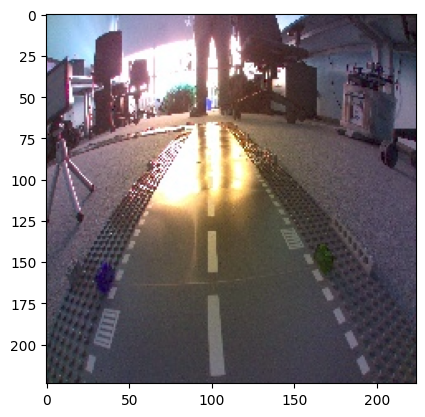

In [6]:
import matplotlib.pyplot as plt

plt.imshow(X[2])
print(y[2])

In [7]:
pd.DataFrame(y)

,0,1
0,0.039062,0.000000
1,0.210938,0.000000
2,0.390625,0.000000
3,0.421875,0.000000
4,0.421875,0.000000
...,...,...
7579,0.398438,0.992188
7580,0.367188,0.992188
7581,0.367188,0.992188
7582,0.375000,0.992188


In [8]:
# TODO cut out bad parts

In [105]:
flipped_X = np.array([tf.image.flip_left_right(x) for x in X])
all_X = np.concatenate([flipped_X, X])

flipped_y = y * (1, -1)
all_y = np.concatenate([flipped_y, y])

augmentation = keras.Sequential(
    [keras.layers.RandomBrightness(0.2), keras.layers.RandomContrast(0.2)]
)

In [113]:
# Controls: SPACE, K, J, Q

IS_SHOW_AUGMENTED = True

i = 0
last_i = None
img = None
is_pause = True
while 1:
    if i != last_i:
        if IS_SHOW_AUGMENTED:
            img = augmentation(all_X[i % len(all_X)]).numpy() / 255
        else:
            img = X[i % len(X)].copy()

        img = cv2.resize(img, np.multiply(img.shape[:-1], 4))

        if IS_SHOW_AUGMENTED:
            cx, cy = all_y[i % len(all_y)]
        else:
            cx, cy = y[i % len(y)]

        img = cv2.putText(
            img,
            f"Frame: {i}, forward: {cx:.3f}, steering: {'0' if cy == 0 else 'L' if cy > 0 else 'R'}{abs(cy):.3f}",
            (16, 48),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2,
        )

    cv2.imshow("Dataset", img)

    last_i = i
    i += 0 if is_pause else 1

    key = cv2.waitKey(30) & 0xFF
    if key == ord("q"):
        break
    elif key == ord(" "):
        is_pause = not is_pause
    elif key == ord("k"):
        i += 1
    elif key == ord("j"):
        i -= 1

cv2.destroyAllWindows()